# Homework 7
1. For the linear regression model, write the python code to train the model using the dataset linreg-data.csv from Lec. 6. In this data set, add 144 to the target variable. Use random initialization of parameters using torch.rand.

	a. Using manually computed gradients

	b. Using semi-manually computing gradients

	c. Automatically computing gradients.

# Imports

In [1]:
import torch
import torch.nn.functional as F
from torch.autograd import grad
import matplotlib.pyplot as plt

# constants
LEARNING_RATE = 0.05
EPOCHS = 100


# Dataset preparation

In [2]:
import pandas as pd

df = pd.read_csv('linreg-data.csv', index_col=0)
X = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float) 
y = torch.tensor(df['y'].values, dtype=torch.float)

# given 144 needs to be added to target variable
y += 144

torch.manual_seed(42)

# shuffle preparation data
shuffle_idx = torch.randperm(y.shape[0], dtype=torch.long)
X, y = X[shuffle_idx], y[shuffle_idx]

# splitting the data into 70:30 ratio
percent_70 = int(shuffle_idx.size(0) * 0.7)

X_train, X_test = X[shuffle_idx[:percent_70]], X[shuffle_idx[percent_70:]]
y_train, y_test = y[shuffle_idx[:percent_70]], y[shuffle_idx[percent_70:]]

# normalize 
mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

# Manual Linear Regression

In [3]:
class ManualLinearRegression:
    def __init__(self, number_of_features: int, seed: int) -> None:

        self.number_of_features = number_of_features
        self.weights = torch.rand(number_of_features, 1, dtype=torch.float)
        self.bias = torch.rand(1, dtype=torch.float)
        torch.manual_seed(seed)

    def forward(self, X: torch.Tensor) -> torch.Tensor:

        # weighted_sum = X * W + b
        weighted_sum = torch.add(torch.mm(X, self.weights), self.bias)
        activation = F.relu(weighted_sum)
        return activation.view(-1)

    def backward(self, X: torch.Tensor, yhat: torch.Tensor, y: torch.Tensor) -> (torch.Tensor, torch.Tensor):
        # Compute derivative of loss w.r.t predictions: (yhat - y)^2 => 2 * (yhat - y)
        gradient_loss_yhat = 2 * (yhat - y)

        # gradient w.r.t. weights: x.T * gradient_loss_yhat averaged over number of samples
        gradient_loss_weights = torch.mm(X.T, gradient_loss_yhat.view(-1, 1)) / y.shape[0]

        # gradient w.r.t. bias: average of gradient_loss_yhat over number of samples
        gradient_loss_bias = torch.sum(gradient_loss_yhat) / y.shape[0]

        # return -ve values
        return -gradient_loss_weights, -gradient_loss_bias

    def loss_function(self, yhat: torch.tensor, y: torch.tensor) -> torch.tensor:

        return torch.mean((yhat - y) ** 2)

    def train(self, X: torch.Tensor, y: torch.Tensor, epochs: int, learning_rate: float = 0.01) -> list:

        cost = []

        for epoch in range(epochs):
            # perform forward pass
            yhat = self.forward(X=X) # i.e. predictions

            # perform backward pass
            negative_gradient_weights, negative_gradient_bias = self.backward(X=X, yhat=yhat, y=y)

            # update weights & bias
            self.weights += learning_rate * negative_gradient_weights
            self.bias += learning_rate * negative_gradient_bias

            # compute new predictions and current loss
            yhat = self.forward(X=X)
            current_loss = self.loss_function(yhat=yhat, y=y)

            print(f"Epoch: {epoch + 1} | Mean Squared Error: {current_loss:.4f}")
            cost.append(current_loss)

        return cost

# Train Manual Linear Regresssion

In [4]:
manual_cost = ManualLinearRegression(number_of_features=X_train.shape[1], seed=42)
manual_cost = manual_cost.train(X=X_train, y=y_train, epochs=EPOCHS, learning_rate=LEARNING_RATE)


Epoch: 1 | Mean Squared Error: 17930.4160
Epoch: 2 | Mean Squared Error: 14593.6504
Epoch: 3 | Mean Squared Error: 11890.8096
Epoch: 4 | Mean Squared Error: 9701.4570
Epoch: 5 | Mean Squared Error: 7928.0444
Epoch: 6 | Mean Squared Error: 6491.5474
Epoch: 7 | Mean Squared Error: 5327.9580
Epoch: 8 | Mean Squared Error: 4385.4292
Epoch: 9 | Mean Squared Error: 3621.9644
Epoch: 10 | Mean Squared Error: 3003.5432
Epoch: 11 | Mean Squared Error: 2502.6113
Epoch: 12 | Mean Squared Error: 2096.8472
Epoch: 13 | Mean Squared Error: 1768.1710
Epoch: 14 | Mean Squared Error: 1501.9368
Epoch: 15 | Mean Squared Error: 1286.2827
Epoch: 16 | Mean Squared Error: 1111.5986
Epoch: 17 | Mean Squared Error: 970.1016
Epoch: 18 | Mean Squared Error: 855.4863
Epoch: 19 | Mean Squared Error: 762.6459
Epoch: 20 | Mean Squared Error: 687.4434
Epoch: 21 | Mean Squared Error: 626.5280
Epoch: 22 | Mean Squared Error: 577.1854
Epoch: 23 | Mean Squared Error: 537.2168
Epoch: 24 | Mean Squared Error: 504.8414
Epoch:

# Semi-Manual Linear Regression

In [5]:
class SemiManualLinearRegression:
    def __init__(self, number_of_features: int, seed: int) -> None:
         
        self.number_of_features = number_of_features
        self.weights = torch.rand(number_of_features, 1, dtype=torch.float, requires_grad=True)
        self.bias = torch.rand(1, dtype=torch.float, requires_grad=True)
        torch.manual_seed(seed)

    def forward(self, X: torch.Tensor) -> torch.Tensor:

        # weighted_sum = X * W + b
        weighted_sum = torch.add(torch.mm(X, self.weights), self.bias)
        activation = F.relu(weighted_sum)
        return activation.view(-1)
        # return weighted_sum.view(-1)

    def loss_function(self, yhat: torch.tensor, y: torch.tensor) -> torch.tensor:

        return torch.mean((yhat - y) ** 2)

    def train(self, X: torch.Tensor, y: torch.Tensor, epochs: int, learning_rate: float = 0.01) -> list:

        cost = []

        for epoch in range(epochs):
            # perform forward pass
            yhat = self.forward(X=X) # i.e. predictions
            current_loss = self.loss_function(yhat=yhat, y=y)

            # perform backward pass
            negative_gradient_weights = grad(current_loss, self.weights, retain_graph=True)[0] * (-1)
            negative_gradient_bias = grad(current_loss, self.bias)[0] * (-1)
            # print(f"Gradient Weights: {negative_gradient_weights}")
            # print(f"Gradient Bias: {negative_gradient_bias}")

            with torch.no_grad():

                # update weights & bias
                self.weights += learning_rate * negative_gradient_weights
                self.bias += learning_rate * negative_gradient_bias

                # compute new predictions and current loss
                yhat = self.forward(X=X)
                current_loss = self.loss_function(yhat=yhat, y=y)
    
                print(f"Epoch: {epoch + 1} | Mean Squared Error: {current_loss:.4f}")
                cost.append(current_loss)

        return cost
    


# Train Semi-Manual Linear Regression

In [6]:
semi_manual_cost = SemiManualLinearRegression(number_of_features=X_train.shape[1], seed=42)
semi_manual_cost = semi_manual_cost.train(X=X_train, y=y_train, epochs=EPOCHS, learning_rate=LEARNING_RATE)

Epoch: 1 | Mean Squared Error: 18867.9609
Epoch: 2 | Mean Squared Error: 15571.3115
Epoch: 3 | Mean Squared Error: 12731.1982
Epoch: 4 | Mean Squared Error: 10389.3340
Epoch: 5 | Mean Squared Error: 8487.2490
Epoch: 6 | Mean Squared Error: 6945.2998
Epoch: 7 | Mean Squared Error: 5695.4653
Epoch: 8 | Mean Squared Error: 4683.0845
Epoch: 9 | Mean Squared Error: 3863.0432
Epoch: 10 | Mean Squared Error: 3198.7996
Epoch: 11 | Mean Squared Error: 2660.7546
Epoch: 12 | Mean Squared Error: 2224.9321
Epoch: 13 | Mean Squared Error: 1871.9105
Epoch: 14 | Mean Squared Error: 1585.9584
Epoch: 15 | Mean Squared Error: 1354.3341
Epoch: 16 | Mean Squared Error: 1166.7153
Epoch: 17 | Mean Squared Error: 1014.7421
Epoch: 18 | Mean Squared Error: 891.6418
Epoch: 19 | Mean Squared Error: 791.9292
Epoch: 20 | Mean Squared Error: 711.1608
Epoch: 21 | Mean Squared Error: 645.7373
Epoch: 22 | Mean Squared Error: 592.7435
Epoch: 23 | Mean Squared Error: 549.8177
Epoch: 24 | Mean Squared Error: 515.0476
Epoc

# Automatic Linear Regression

In [7]:
class AutoLinearRegression(torch.nn.Module):
	def __init__(self, number_of_features: int) -> None:
		super().__init__()
		self.linear = torch.nn.Linear(number_of_features, 1)

		# adding detach() for resolving `a leaf Variable that requires grad is being used in an in-place operation.`
		self.linear.weight.detach()
		self.linear.bias.detach()

	def forward(self, X: torch.Tensor) -> torch.Tensor:
		weighted_sum = self.linear(X)
		activation = F.relu(weighted_sum)
		return activation.view(-1)
		# return weighted_sum.view(-1)

def train(model, x: torch.Tensor, y: torch.Tensor, epochs: int, learning_rate: float = 0.01, seed: int = 42) -> list:
	cost = []

	torch.manual_seed(seed=seed)

	optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

	for epoch in range(epochs):

		# perform forward pass
		yhat = model.forward(X=x)

		# compute mean squared error loss
		loss = F.mse_loss(yhat, y)
		loss.backward()

		# update the weights according to the optimization method
		optimizer.step()

		# reset gradients from previous iteration
		optimizer.zero_grad()

		with torch.no_grad():
			yhat = model.forward(X=x)
			current_loss = F.mse_loss(yhat, y)
			print(f"Epoch: {epoch + 1} | Mean Squared Error: {current_loss:.4f}")
			cost.append(current_loss)

	return cost

In [8]:
model = AutoLinearRegression(number_of_features=X_train.shape[1])
auto_cost = train(model=model, x=X_train, y=y_train, epochs=EPOCHS, learning_rate=LEARNING_RATE, seed=42)

Epoch: 1 | Mean Squared Error: 19566.3809
Epoch: 2 | Mean Squared Error: 16379.1133
Epoch: 3 | Mean Squared Error: 13466.9258
Epoch: 4 | Mean Squared Error: 11019.6006
Epoch: 5 | Mean Squared Error: 9003.8301
Epoch: 6 | Mean Squared Error: 7366.2363
Epoch: 7 | Mean Squared Error: 6037.6699
Epoch: 8 | Mean Squared Error: 4960.2788
Epoch: 9 | Mean Squared Error: 4087.5649
Epoch: 10 | Mean Squared Error: 3380.6582
Epoch: 11 | Mean Squared Error: 2808.0571
Epoch: 12 | Mean Squared Error: 2344.2432
Epoch: 13 | Mean Squared Error: 1968.5498
Epoch: 14 | Mean Squared Error: 1664.2345
Epoch: 15 | Mean Squared Error: 1417.7361
Epoch: 16 | Mean Squared Error: 1218.0699
Epoch: 17 | Mean Squared Error: 1056.3380
Epoch: 18 | Mean Squared Error: 925.3336
Epoch: 19 | Mean Squared Error: 819.2188
Epoch: 20 | Mean Squared Error: 733.2647
Epoch: 21 | Mean Squared Error: 663.6412
Epoch: 22 | Mean Squared Error: 607.2454
Epoch: 23 | Mean Squared Error: 561.5642
Epoch: 24 | Mean Squared Error: 524.5619
Epoc

# Graph Plot

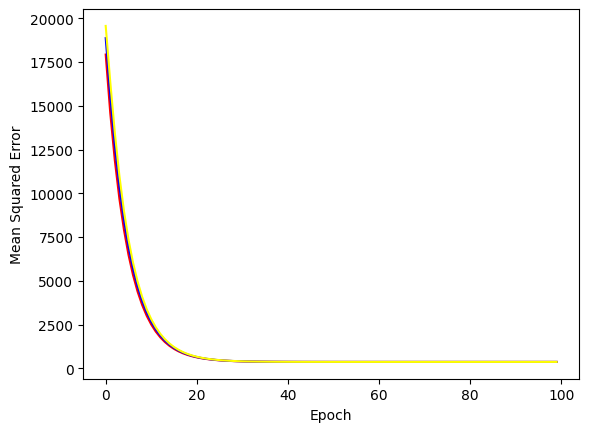

In [9]:
plt.plot(range(len(manual_cost)), manual_cost, color='red')
plt.plot(range(len(semi_manual_cost)), semi_manual_cost, color='blue')
plt.plot(range(len(auto_cost)), auto_cost, color='yellow')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()